# Karachi AQI Predictor — Notebook Test (Local + Hopsworks)

**Run cells in order**. If kernel restarts, just run **Setup** cell again.


In [1]:
# ✅ SETUP (RUN FIRST)
import sys
from pathlib import Path

ROOT = Path.cwd()  # should be C:\aqipredictor when you open notebook from project folder
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Python executable:", sys.executable)
print("Project ROOT:", ROOT)


Python executable: C:\aqipredictor\.venv\Scripts\python.exe
Project ROOT: C:\aqipredictor


In [3]:
# ✅ Load config from .env
from src.config import (
    HOPSWORKS_PROJECT, HOPSWORKS_API_KEY,
    HOPSWORKS_HOST, HOPSWORKS_PORT,
    LAT, LON
)

print("Hopsworks project:", HOPSWORKS_PROJECT)
print("Host:", HOPSWORKS_HOST, "Port:", HOPSWORKS_PORT)
print("LAT/LON:", LAT, LON)
print("API key loaded:", bool(HOPSWORKS_API_KEY))


Hopsworks project: aqipredictor
Host: eu-west.cloud.hopsworks.ai Port: 443
LAT/LON: 24.8607 67.0011
API key loaded: True


In [4]:
# ✅ Login to Hopsworks + load Online Feature Groups
from src.data.hopsworks_client import get_project_and_fs
from src.ml.features import build_hourly_join

project, fs = get_project_and_fs()
print("✅ Logged in:", project.name)
print("✅ Feature store:", fs.name)

weather_fg = fs.get_feature_group("karachi_weather_features_online", version=1)
poll_fg    = fs.get_feature_group("karachi_pollution_aqi_online", version=1)

w_on = weather_fg.read(online=True)
p_on = poll_fg.read(online=True)

print("Weather rows:", len(w_on))
print("Pollution rows:", len(p_on))

df_hourly = build_hourly_join(w_on, p_on)
print("✅ Joined hourly rows:", len(df_hourly))
df_hourly.head()


2026-01-30 05:25:40,905 INFO: Initializing external client
2026-01-30 05:25:40,913 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-30 05:25:43,830 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3231
✅ Logged in: aqipredictor
✅ Feature store: aqipredictor_featurestore
Weather rows: 2904
Pollution rows: 2857
✅ Joined hourly rows: 2857


,temp,humidity,wind,pressure,hour,dow,month,pm2_5,pm10,no2,so2,co,o3,aqi,ts_key
timestamp,,,,,,,,,,,,,,,
2025-09-29 23:00:00+00:00,28.8,73,6.9,999.8,23,0,9,16.68,82.23,0.29,0.72,94.14,47.22,61,1759186800
2025-09-30 00:00:00+00:00,28.7,71,8.3,999.5,0,1,9,17.99,87.56,0.43,0.77,100.43,48.19,63,1759190400
2025-09-30 01:00:00+00:00,28.3,83,7.2,1000.3,1,1,9,14.71,77.64,0.11,0.67,91.27,48.64,56,1759194000
2025-09-30 02:00:00+00:00,28.5,79,6.8,1000.9,2,1,9,15.43,79.89,0.11,0.65,91.70,50.11,58,1759197600
2025-09-30 03:00:00+00:00,30.0,67,4.3,1001.4,3,1,9,16.08,81.29,0.13,0.61,92.03,51.34,59,1759201200


In [5]:
# ✅ Resample to 6H / 12H + lag/rolling features
from src.ml.features import resample_df, add_lag_roll

df_6h  = add_lag_roll(resample_df(df_hourly, "6H"))
df_12h = add_lag_roll(resample_df(df_hourly, "12H"))

print("6H rows:", len(df_6h))
print("12H rows:", len(df_12h))

df_6h.head()


6H rows: 474
12H rows: 238


,temp,humidity,wind,pressure,hour,dow,month,pm2_5,pm10,no2,...,co,o3,aqi,ts_key,pm25_roll24,aqi_roll24,aqi_lag1,aqi_lag24,pm25_lag1,pm25_lag24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-30 18:00:00+00:00,27.500000,83.000000,8.783333,1000.750000,18,1,9,19.871667,80.998333,0.111667,...,91.761667,56.396667,67.333333,1.759264e+09,19.084167,65.625000,70.166667,61.000000,21.161667,16.680000
2025-10-01 00:00:00+00:00,28.016667,80.666667,9.116667,1001.633333,0,2,10,15.805000,41.023333,3.341667,...,196.831667,50.558333,59.000000,1.759286e+09,18.965000,65.500000,67.333333,59.500000,19.871667,16.281667
2025-10-01 06:00:00+00:00,32.750000,55.500000,13.333333,1000.683333,6,2,10,23.780000,44.413333,1.050000,...,174.825000,102.443333,75.500000,1.759307e+09,20.154583,68.000000,59.000000,65.500000,15.805000,19.021667
2025-10-01 12:00:00+00:00,31.150000,63.000000,8.816667,1001.033333,12,2,10,23.555000,37.896667,1.225000,...,175.483333,106.375000,75.333333,1.759329e+09,20.752917,69.291667,75.500000,70.166667,23.780000,21.161667
2025-10-01 18:00:00+00:00,28.016667,78.666667,6.833333,1002.500000,18,2,10,12.421667,19.965000,1.535000,...,140.940000,67.548333,49.833333,1.759351e+09,18.890417,64.916667,75.333333,67.333333,23.555000,19.871667


In [6]:
# ✅ Train 3 models (on 6H by default)
from src.ml.train import train_three_models

results_df, best_name, trained, preds_table = train_three_models(df_6h)

print("🏆 Best model:", best_name)
results_df


🏆 Best model: RF


,Model,MAE,RMSE,R2
2,RF,1.571125,3.644787,0.991130
1,GBR,1.830211,3.742379,0.990649
0,Ridge,8.167546,10.259625,0.929719


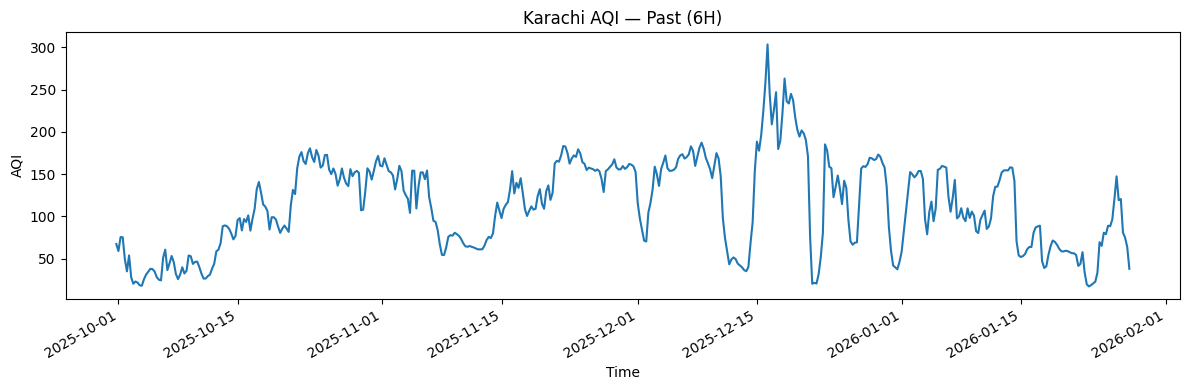

<Figure size 1200x400 with 0 Axes>

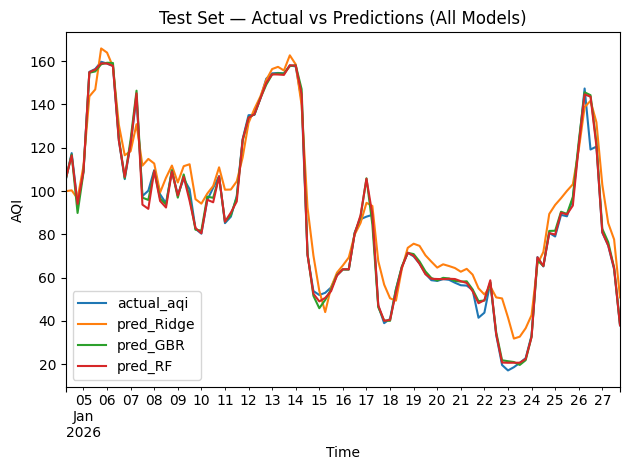

In [7]:
# ✅ Plot: Past AQI + Test predictions (all 3 models)
import matplotlib.pyplot as plt

# Past AQI
plt.figure(figsize=(12,4))
df_6h["aqi"].plot()
plt.title("Karachi AQI — Past (6H)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

# Test predictions
preds_plot = preds_table.set_index("timestamp")
plt.figure(figsize=(12,4))
preds_plot.plot()
plt.title("Test Set — Actual vs Predictions (All Models)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()


In [8]:
# ✅ Future predictions (Next 3 days) — Hourly + Daily (All models)
from src.ml.forecast import future_predictions_all_models, daily_predictions

future_hourly = future_predictions_all_models(df_hourly, trained, LAT, LON)
future_daily  = daily_predictions(future_hourly)

future_hourly.head(), future_daily


(                           pred_Ridge   pred_GBR    pred_RF
 timestamp                                                  
 2026-01-30 00:00:00+00:00   54.290694  28.892176  26.966667
 2026-01-30 01:00:00+00:00   54.148556  28.937931  26.966667
 2026-01-30 02:00:00+00:00   53.807870  28.925874  26.933750
 2026-01-30 03:00:00+00:00   53.405237  28.925874  26.945000
 2026-01-30 04:00:00+00:00   53.603828  28.937931  26.926667,
                            pred_Ridge   pred_GBR    pred_RF
 timestamp                                                  
 2026-01-30 00:00:00+00:00   54.491775  29.154206  27.016771
 2026-01-31 00:00:00+00:00   52.651062  29.175691  26.989514
 2026-02-01 00:00:00+00:00   51.318560  29.197873  26.988281)

<Figure size 1200x400 with 0 Axes>

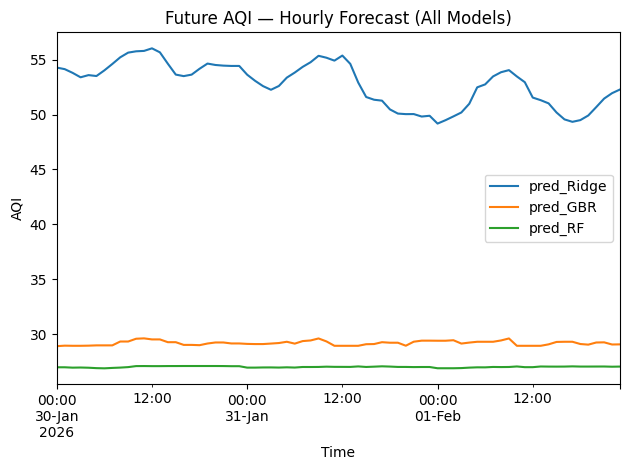

<Figure size 800x400 with 0 Axes>

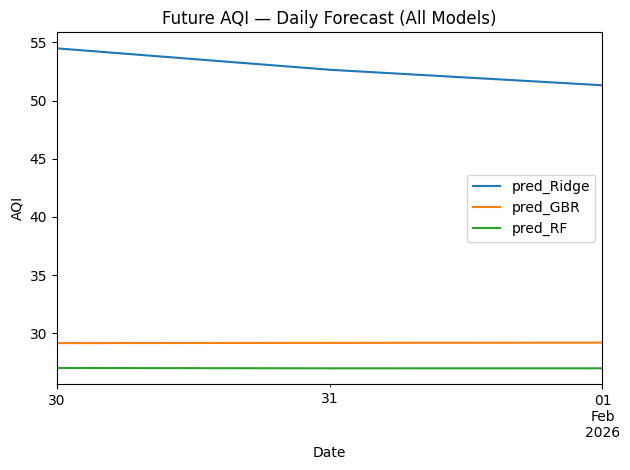

In [9]:
# ✅ Plot: Future hourly + daily
plt.figure(figsize=(12,4))
future_hourly.plot()
plt.title("Future AQI — Hourly Forecast (All Models)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
future_daily.plot()
plt.title("Future AQI — Daily Forecast (All Models)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()
